In [65]:
from mech_module import *
import numpy as np
import pandas as pd
from pyswarm import pso
import matplotlib.pyplot as plt

In [95]:
# component definitions
def a_t1(alpha, a_t):
    return alpha * a_t

def b_t1(beta, Y_t):
    return beta * Y_t

def c_t1(gamma, delta, t):
    # the seasonal component is a exponentially decreasing function of time that repeats every 365 days and looks like a poison distribution
    return gamma * np.exp(-delta * t/365) 

def d_t(sigma):
    return np.random.normal(0, sigma)

def Y_t1(at, bt, ct, dt):
    return at + bt + ct + dt

In [93]:

# import data
data = pd.read_csv('15021_gdf.csv')
# column names ['date', 'flow', 'nan']
# first 18 rows are descriptions
# the flow is average daily flow in m^3/s
data = data[19:]
# remove last column
data = data.iloc[:, :-1]
# name columns
data.columns = ['date', 'flow']
# convert flow to numeric
data['flow'] = pd.to_numeric(data['flow'], errors='coerce')
# convert date to datetime
data['date'] = pd.to_datetime(data['date'])

# station area width = 7.5m , depth = approx 0.5m (on visual inspection)
# https://nrfa.ceh.ac.uk/data/station/info/15021

# convert flow to velocity
data['velocity'] = data['flow'] / (7.5 * 0.5)


In [96]:
# split the data
n = len(data)
train = data.iloc[:int(n * 0.5)]
test = data.iloc[int(n * 0.5):]

# define the objective function
def objective(params, data):
    alpha, beta, gamma, delta, sigma = params
    a = data['velocity'].iloc[0]
    b = data['velocity'].iloc[0]
    c = c_t1(gamma, delta, 1)
    d = d_t(sigma)
    Y = Y_t1(a, b, c, d)
    error = 0
    for t in range(1, len(data)):
        a = a_t1(alpha, a)
        b = b_t1(beta, Y)
        c = c_t1(gamma, delta, t)
        d = d_t(sigma)
        Y = Y_t1(a, b, c, d)
        error += (data['velocity'].iloc[t] - Y) ** 2
    return error

# initial guesses
#  0.99969635 -0.27333223 -0.01627534  0.68633705  0.12686814
alpha = 0.99969635
beta = -0.27333223
gamma = -0.01627534
delta = 0.68633705
sigma = 0.12686814
params = [alpha, beta, gamma, delta, sigma]

# perform the optimisation
result = pso(objective,[-1,-1,-1,-1,0], [5, 5, 5,5,5], args=(train,), swarmsize=50, maxiter=50, minstep=1e-8, minfunc=1e-8, debug=True)


No constraints given.


/var/folders/4d/1cd5pk9s6f7_prxws19jm1fw0000gn/T/ipykernel_70897/4141376829.py:21: RuntimeWarning: overflow encountered in double_scalars
  error += (data['velocity'].iloc[t] - Y) ** 2
/var/folders/4d/1cd5pk9s6f7_prxws19jm1fw0000gn/T/ipykernel_70897/1421698081.py:3: RuntimeWarning: overflow encountered in double_scalars
  return alpha * a_t
/var/folders/4d/1cd5pk9s6f7_prxws19jm1fw0000gn/T/ipykernel_70897/1421698081.py:6: RuntimeWarning: overflow encountered in double_scalars
  return beta * Y_t
/var/folders/4d/1cd5pk9s6f7_prxws19jm1fw0000gn/T/ipykernel_70897/1421698081.py:16: RuntimeWarning: overflow encountered in double_scalars
  return at + bt + ct + dt
/var/folders/4d/1cd5pk9s6f7_prxws19jm1fw0000gn/T/ipykernel_70897/1421698081.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return at + bt + ct + dt


New best for swarm at iteration 1: [0.43356887 0.4043843  2.79063208 3.13904342 0.85453994] 9202.42283345397
Best after iteration 1: [0.43356887 0.4043843  2.79063208 3.13904342 0.85453994] 9202.42283345397
New best for swarm at iteration 2: [0.80418355 0.63216627 4.26739822 4.07797031 0.23389379] 7665.92118602149
New best for swarm at iteration 2: [-1.          0.64184954  1.47669344  5.          0.        ] 4051.276120724663
Best after iteration 2: [-1.          0.64184954  1.47669344  5.          0.        ] 4051.276120724663
New best for swarm at iteration 3: [0.21970368 0.2884515  1.76736085 3.89034947 0.        ] 2241.8876793593377
New best for swarm at iteration 3: [-0.82809796  0.19316279  1.62258813  4.76435456  0.        ] 2192.6831474028036
Best after iteration 3: [-0.82809796  0.19316279  1.62258813  4.76435456  0.        ] 2192.6831474028036
New best for swarm at iteration 4: [-0.74214694 -0.03118059  1.69553547  4.64653184  0.        ] 2179.378734468877
Best after iterati

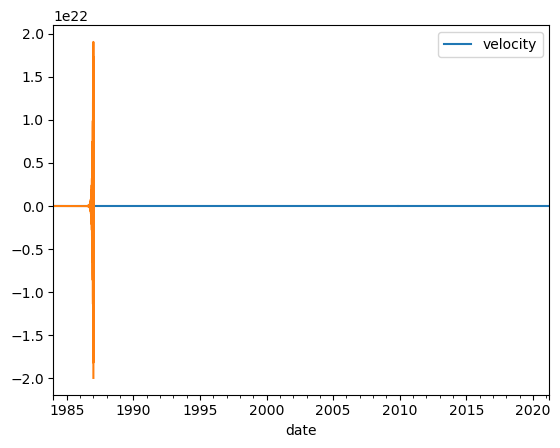

In [102]:
# get the parameters
alpha, beta, gamma, delta, sigma = result[0]
# 0.8704158  -0.17166893  0.86192271  0.09629691  0.   
# 0.98243488 -0.33847091  0.55787363  0.51328608  0.        
alpha= alpha*2
# beta= beta*2
# gamma= gamma
# delta= delta*3
sigma= sigma*10

# plot the model against the data
a = train['velocity'].iloc[0]
b = train['velocity'].iloc[0]
c = c_t1(gamma, delta, 1)
d = d_t(sigma)
Y = Y_t1(a, b, c, d)

model = [Y]
for t in range(1, len(train)):
    a = a_t1(alpha, a)
    b = b_t1(beta, Y)
    c = c_t1(gamma, delta, t)
    d = d_t(sigma)
    Y = Y_t1(a, b, c, d)
    model.append(Y)

# adjust so that no negative values
model = np.array(model)
# model[model < 0] = 0

# plot the model against the data 
data.plot(x='date', y='velocity')
plt.plot(train['date'], model)
plt.show()